# Power Calculation for GWAS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.multitest import fdrcorrection
import seaborn as sns

Simulations are great for testing the logic of your mental model, or for building you intuition of a system, but they are also awesome for experimental design!! 

A common question when designing an experiment is "How many samples do I need?". However, practically speaking, the answer in evolutionary biology is generally "As many as I can afford". 

Maybe a better version of this question is then "For X number of samples, what is the minumum effect size that my statistical method will be able to detect?". This question is the goal of statistical power analysis, which is a complicated area that often requires a lot of expertise and experience (if you're interested to read more, here's an article to get you started https://statisticsbyjim.com/hypothesis-testing/sample-size-power-analysis/). Here, we will see how simulating your data can help answer this question! 
***
As an example, lets say we are interested in the genetic basis of a trait, so we have decided to conduct a GWAS. To keep it simple, were going to assume that our trait has a purely addative basis (as most GWAS do), which means that our model of the system is:

$P = \Sigma (\beta * G) + E$

This basically says that the phenotype $P$ of individuals is the sum of the genotypes $G$ across all sites, multiplied by the effects of those sites $\beta$, plus variation from to the environment $E$.

The idea here is to simulate our data, using known effect sizes of decreasing strength, then perform a GWAS on the simulated data to see how many of the effecting sites we manage to find. 

To simulate our data, we will need three things: a 2D array of genotypes, a 1D array of effect sizes, and a 1D array of envirnmental effects. We will then use our formula above to calculate the phenotypes, and use the phenotypes and the genotypes for our mock GWAS.
***

Lets first start off with some basic parameters

In [2]:
sample_size = 1000
genome_size = 10_000

Then we will simulate the enviromental effects and the effect sizes. For the environmental effects, we will just draw them from a normal distribution with $\sigma$ = 1, with 1 per individual. For the effect sizes, the vast majority will be zero, but one every 500 sites will have a positive effect, starting at 2 and decreasing by 0.1 each time. 

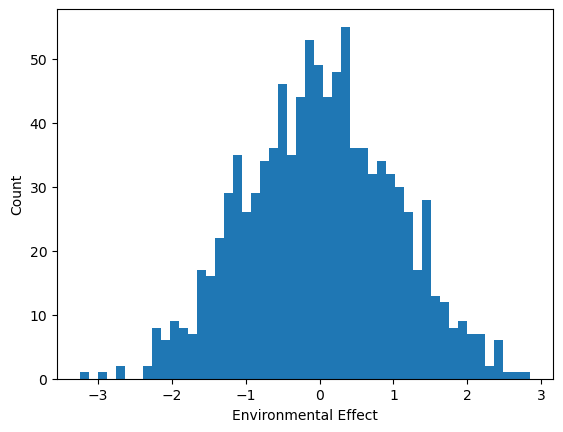

In [3]:
## 1D array of environmental effects
envs = np.random.normal(0,1, size = sample_size)

## Plotting distribution of environmental effects 
plt.hist(envs, bins = 50)
plt.xlabel('Environmental Effect')
plt.ylabel('Count');

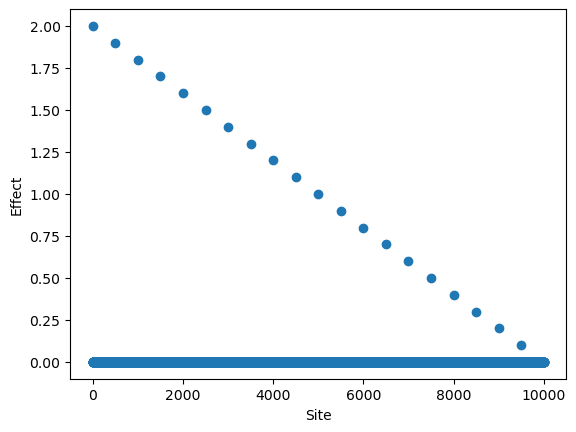

In [4]:
## 1D array of effect sizes
effects = np.zeros(genome_size)
for i in range(20):
    effects[i*500] = ((20 - i)/20)*2 #Adding a non-zero effect every 500 sites
    
## Plotting the effect sizes 
plt.scatter(range(genome_size), effects)
plt.xlabel('Site')
plt.ylabel('Effect');

Now lets simulate the genotypes. For this, we will have to first take into account what would be realistic values for allele frequency at each site. These frequencies are subject to many factors, which we will not go into, but if you already have some data its possible to get the distribution allele frequencies for each site directly from there. 

For our simulation, we will assume that the distribution of allele frequencies across sites follows what is expected under neutral evolution, i.e. no population size changes or selection. In this case, the distribution of allele frequencies across sites (also called the site frequency spectrum, SFS) is expected to follow

$x_i = \theta \frac{1}{i}$

Where $i$ is the frequency of the derived allele in the samples (i.e. 1 if its found once, 2 if twice, etc.), $x_i$ is the number of sites with that allele frequency, and $\theta$ is the population scaled mutation rate ($2N\mu$, though since we are just interested in the shape not the scale we wont use this). So to simulate the genotypes accurately, we will need to make sure that they follow the neutral SFS given by that formula.

To accomplish this, first we need to figure out how to choose the allele frequency for each site. An easy way to do this is to create a large array of values (each value being an allele frequency) with the number of times the value appears in the array proportional to the frequency expected in our neutral SFS (`frequency`). In other words, since sites with only a single derived allele across the population are the most common, the array would contain more 1s than any other number, then the second most common would be 2s, etc. This array will be called `values_to_sample`. 

In [5]:
i = np.linspace(1,2*sample_size,2*sample_size).astype(int)/(2*sample_size) # Allele Frequencies - sample size is 2X because were thinking of a diploid
frequency = 1/np.linspace(1,2*sample_size,2*sample_size) # of sites at each Alle Frequency
values_to_sample = np.repeat(i,np.floor(frequency*sample_size).astype(int)) # array of allele frequency values 

Then what we need to do is construct a vector of genotypes for each site, with the derived allele frequency chosen randomly from the `values_to_sample` array. To get the genotypes, we will use binomial sampling with $p$ = our derived allele frequency. We will do this twice (one for each copy of the chromosome since we're simulating a diploid organism) and add the values together. This will result in a vector of 0's, 1's, and 2's for homozygous ancestral, heterozygous, and homozygous derived. Repeating this for each site gives us our 2D genotype array `genos`.

In [6]:
genos = np.empty((sample_size,genome_size))
for i in range(genome_size):
    p = np.random.choice(values_to_sample)
    genos[:,i] = np.random.binomial(1,p,sample_size) + np.random.binomial(1,p,sample_size) # doing it twice for diploid

Now we can check if the site frequency spectrum of our simulated genotypes (roughly) matches the site frequency spectrum for neutral evolution.

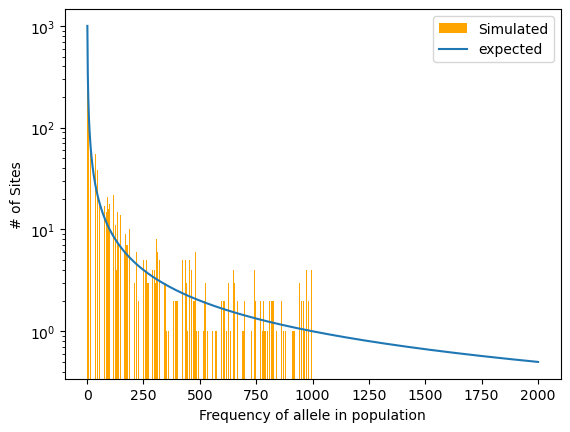

In [7]:
plt.hist(genos.sum(axis = 0), bins = 2000, label = 'Simulated', color = 'orange');
plt.plot(np.linspace(1,2*sample_size,2*sample_size),1/np.linspace(1,2*sample_size,2*sample_size)*1000, label = 'expected')
plt.yscale('log')
plt.legend()
plt.xlabel('Frequency of allele in population')
plt.ylabel('# of Sites');

Looks good! Lastly, we will calculate our phenotypes following $P = \Sigma (\beta * G) + E$, and take a look at their distribution.

Text(0, 0.5, 'Count')

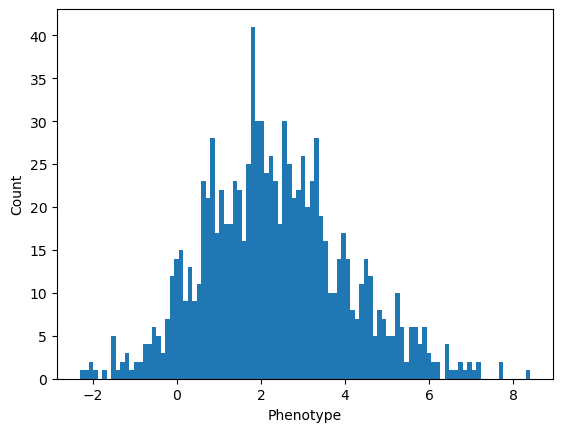

In [8]:
## Calculating phenotypes
phenos = (effects*genos).sum(axis = 1) + envs

## Distribution of phenotypes
plt.hist(phenos,bins = 100);
plt.xlabel('Phenotype')
plt.ylabel('Count')

To run the GWAS, we will use the ordinary least squares method of linear regression from the statsmodels library. We will loop over each genotype and record the estimate of effect size and p-value that the OLS returns. Then, we can correct our p-values for multiple testing using the false discovery rate (FDR), plot a manhattan and volcano plot of our results (yellow means significant), and lastly see how accurately we were able to recover the effect sizes

In [9]:
## Running GWAS
ps = np.zeros(genome_size)
bs = np.zeros(genome_size)

for i in range(genome_size):
    X = genos[:,i]
    X = sm.add_constant(X, has_constant = 'add') 
    mod = sm.OLS(phenos, X).fit()
    ps[i] = mod.pvalues[1]
    bs[i] = mod.params[1]
    
q_vals = fdrcorrection(ps, alpha = 0.05)

Text(0, 0.5, '-log(p)')

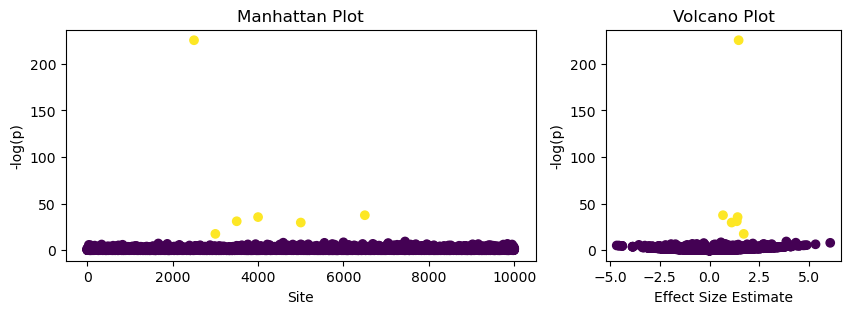

In [10]:
## Manhattan and Volcano Plots
fig, axs = plt.subplots(1,2,figsize = (10,3), gridspec_kw={'width_ratios': [2, 1],'height_ratios': [1],})

axs[0].scatter(range(genome_size), -np.log(ps), c = q_vals[0].astype(int))
axs[0].set_title('Manhattan Plot')
axs[0].set_xlabel('Site')
axs[0].set_ylabel('-log(p)')

axs[1].scatter(bs, -np.log(ps), c = q_vals[0].astype(int))
axs[1].set_title('Volcano Plot')
axs[1].set_xlabel('Effect Size Estimate')
axs[1].set_ylabel('-log(p)')

In [11]:
## Estimated vs Actual Effect Sizes
print('# of significant loci', q_vals[0].sum())
print('% of true effect loci found',q_vals[0][::500].sum()/20)

truths = effects[::500][q_vals[0][::500]] 
ests = bs[::500][q_vals[0][::500]]
diffs = truths - ests

print('\nTruth Estimate Difference')
for i in range(len(diffs)):
    print(truths[i],ests[i],diffs[i])

# of significant loci 6
% of true effect loci found 0.3

Truth Estimate Difference
1.5 1.4639268407106338 0.03607315928936616
1.4 1.7210252047849364 -0.32102520478493646
1.3 1.3729761304759092 -0.07297613047590912
1.2 1.4123689128005075 -0.21236891280050751
1.0 1.1129174549930931 -0.11291745499309314
0.7 0.6780480871708724 0.021951912829127562


So it looks like we were abble to find about 1/3rd of the true effect loci, though the smallest effect size (in my sim) was 0.8
***
1000 is a decently large sample size, though many studies do GWAS with less. Lets see what happens with half of the samples...

# of significant loci 6
% of true effect loci found 0.25

Truth Estimate Difference
1.6 1.624728181736729 -0.02472818173672886
1.4 1.3225676468088736 0.07743235319112629
1.1 1.592407604260698 -0.49240760426069796
0.9 1.0345985237419137 -0.13459852374191372
0.8 0.8327213960053452 -0.03272139600534518


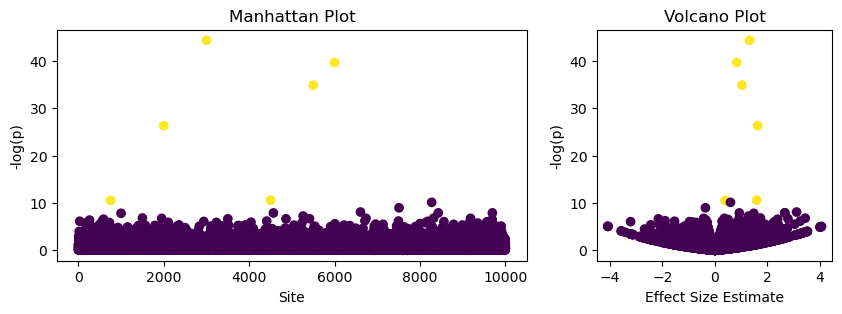

In [12]:
sample_size = 500
genome_size = 10_000

## 1D array of environmental effects
envs = np.random.normal(0,1, size = sample_size)

## 1D array of effect sizes
effects = np.zeros(genome_size)
for i in range(20):
    effects[i*500] = ((20 - i)/20)*2

## 2D array of genotypes
i = np.linspace(1,2*sample_size,2*sample_size).astype(int)/(2*sample_size) # Allele Frequencies
frequency = 1/np.linspace(1,2*sample_size,2*sample_size) # Frequency of each Alle Frequency
values_to_sample = np.repeat(i,np.floor(frequency*sample_size).astype(int)) # array of allele frequency values 

genos = np.empty((sample_size,genome_size))
for i in range(genome_size):
    p = np.random.choice(values_to_sample)
    genos[:,i] = np.random.binomial(1,p,sample_size) + np.random.binomial(1,p,sample_size) # doing it twice for diploid
    
## Calculating phenotypes
phenos = (effects*genos).sum(axis = 1) + envs

## Running GWAS
ps = np.zeros(genome_size)
bs = np.zeros(genome_size)

for i in range(genome_size):
    X = genos[:,i]
    X = sm.add_constant(X, has_constant = 'add') 
    mod = sm.OLS(phenos, X).fit()
    ps[i] = mod.pvalues[1]
    bs[i] = mod.params[1]
    
q_vals = fdrcorrection(ps, alpha = 0.05)

## Manhattan and Volcano Plots
fig, axs = plt.subplots(1,2,figsize = (10,3), gridspec_kw={'width_ratios': [2, 1],'height_ratios': [1],})

axs[0].scatter(range(genome_size), -np.log(ps), c = q_vals[0].astype(int))
axs[0].set_title('Manhattan Plot')
axs[0].set_xlabel('Site')
axs[0].set_ylabel('-log(p)')

axs[1].scatter(bs, -np.log(ps), c = q_vals[0].astype(int))
axs[1].set_title('Volcano Plot')
axs[1].set_xlabel('Effect Size Estimate')
axs[1].set_ylabel('-log(p)')

## Estimated vs Actual Effect Sizes
print('# of significant loci', q_vals[0].sum())
print('% of true effect loci found',q_vals[0][::500].sum()/20)

truths = effects[::500][q_vals[0][::500]] 
ests = bs[::500][q_vals[0][::500]]
diffs = truths - ests

print('\nTruth Estimate Difference')
for i in range(len(diffs)):
    print(truths[i],ests[i],diffs[i])

Now we get far fewer significant loci, though depending on the allele frequencies some loci of smaller effect might still be detectable. 
***
Now lets go the other way and see what happens with a huge number of samples...

/var/folders/9p/tdsfbkc524j05kttcf9bm6240000gp/T/ipykernel_53588/926620739.py:41: RuntimeWarning: divide by zero encountered in log
  axs[0].scatter(range(genome_size), -np.log(ps), c = q_vals[0].astype(int))
/var/folders/9p/tdsfbkc524j05kttcf9bm6240000gp/T/ipykernel_53588/926620739.py:46: RuntimeWarning: divide by zero encountered in log
  axs[1].scatter(bs, -np.log(ps), c = q_vals[0].astype(int))


# of significant loci 14
% of true effect loci found 0.6

Truth Estimate Difference
2.0 1.9891843833144949 0.010815616685505125
1.9 1.8773366596343113 0.022663340365688622
1.8 1.6645097396763808 0.13549026032361922
1.7 1.765128743339642 -0.06512874333964214
1.6 1.825667755336596 -0.225667755336596
1.5 1.397721457661941 0.102278542338059
1.4 1.414132773100508 -0.01413277310050809
1.2 1.08575646470533 0.11424353529467002
0.6 0.5989309393205268 0.0010690606794732105
0.5 0.47569263197432243 0.024307368025677567
0.4 0.37240028942739234 0.027599710572607683
0.3 0.2512723826497138 0.04872761735028619


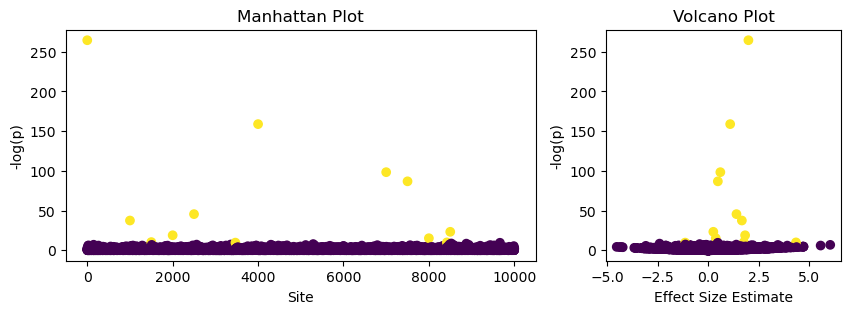

In [13]:
sample_size = 10_000
genome_size = 10_000

## 1D array of environmental effects
envs = np.random.normal(0,1, size = sample_size)

## 1D array of effect sizes
effects = np.zeros(genome_size)
for i in range(20):
    effects[i*500] = ((20 - i)/20)*2

## 2D array of genotypes
i = np.linspace(1,2*sample_size,2*sample_size).astype(int)/(2*sample_size) # Allele Frequencies
frequency = 1/np.linspace(1,2*sample_size,2*sample_size) # Frequency of each Alle Frequency
values_to_sample = np.repeat(i,np.floor(frequency*sample_size).astype(int)) # array of allele frequency values 

genos = np.empty((sample_size,genome_size))
for i in range(genome_size):
    p = np.random.choice(values_to_sample)
    genos[:,i] = np.random.binomial(1,p,sample_size) + np.random.binomial(1,p,sample_size) # doing it twice for diploid
    
## Calculating phenotypes
phenos = (effects*genos).sum(axis = 1) + envs

## Running GWAS
ps = np.zeros(genome_size)
bs = np.zeros(genome_size)

for i in range(genome_size):
    X = genos[:,i]
    X = sm.add_constant(X, has_constant = 'add') 
    mod = sm.OLS(phenos, X).fit()
    ps[i] = mod.pvalues[1]
    bs[i] = mod.params[1]
    
q_vals = fdrcorrection(ps, alpha = 0.05)

## Manhattan and Volcano Plots
fig, axs = plt.subplots(1,2,figsize = (10,3), gridspec_kw={'width_ratios': [2, 1],'height_ratios': [1],})

axs[0].scatter(range(genome_size), -np.log(ps), c = q_vals[0].astype(int))
axs[0].set_title('Manhattan Plot')
axs[0].set_xlabel('Site')
axs[0].set_ylabel('-log(p)')

axs[1].scatter(bs, -np.log(ps), c = q_vals[0].astype(int))
axs[1].set_title('Volcano Plot')
axs[1].set_xlabel('Effect Size Estimate')
axs[1].set_ylabel('-log(p)')

## Estimated vs Actual Effect Sizes
print('# of significant loci', q_vals[0].sum())
print('% of true effect loci found',q_vals[0][::500].sum()/20)

truths = effects[::500][q_vals[0][::500]] 
ests = bs[::500][q_vals[0][::500]]
diffs = truths - ests

print('\nTruth Estimate Difference')
for i in range(len(diffs)):
    print(truths[i],ests[i],diffs[i])

/var/folders/9p/tdsfbkc524j05kttcf9bm6240000gp/T/ipykernel_53588/3293223784.py:8: RuntimeWarning: divide by zero encountered in log
  axs[1].scatter(bs, -np.log(ps), c = q_vals[0].astype(int))


Text(0, 0.5, '-log(p)')

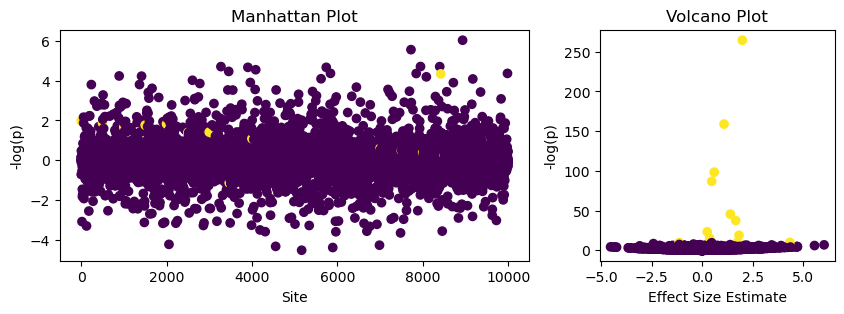

In [14]:
fig, axs = plt.subplots(1,2,figsize = (10,3), gridspec_kw={'width_ratios': [2, 1],'height_ratios': [1],})

axs[0].scatter(range(genome_size), bs, c = q_vals[0].astype(int))
axs[0].set_title('Manhattan Plot')
axs[0].set_xlabel('Site')
axs[0].set_ylabel('-log(p)')

axs[1].scatter(bs, -np.log(ps), c = q_vals[0].astype(int))
axs[1].set_title('Volcano Plot')
axs[1].set_xlabel('Effect Size Estimate')
axs[1].set_ylabel('-log(p)')

Nice! Looks like we were able to recover most of the effecting sites this time, though at 10X the cost of the original sample size.

In [21]:
sample_size = 20_000
genome_size = 10_000

## 1D array of environmental effects
envs = np.random.normal(0,1, size = sample_size)

## 1D array of effect sizes
effects = np.zeros(genome_size)
for i in range(20):
    effects[i*500] = ((20 - i)/20)*2

## 2D array of genotypes
i = np.linspace(1,2*sample_size,2*sample_size).astype(int)/(2*sample_size) # Allele Frequencies
frequency = 1/np.linspace(1,2*sample_size,2*sample_size) # Frequency of each Alle Frequency
values_to_sample = np.repeat(i,np.floor(frequency*sample_size).astype(int)) # array of allele frequency values 

genos = np.empty((sample_size,genome_size))
for i in range(genome_size):
    p = np.random.choice(values_to_sample)
    genos[:,i] = np.random.binomial(1,p,sample_size) + np.random.binomial(1,p,sample_size) # doing it twice for diploid
    
## Calculating phenotypes
phenos = (effects*genos).sum(axis = 1) + envs



In [23]:
genos[:2,:].shape

(2, 10000)

In [29]:
def run_gwas(genos,phenos):
    ## Running GWAS
    ps = np.zeros(genome_size)
    bs = np.zeros(genome_size)

    for i in range(genome_size):
        X = genos[:,i]
        X = sm.add_constant(X, has_constant = 'add') 
        mod = sm.OLS(phenos, X).fit()
        ps[i] = mod.pvalues[1]
        bs[i] = mod.params[1]

    q_vals = fdrcorrection(ps, alpha = 0.05)

    ## Manhattan and Volcano Plots
    fig, axs = plt.subplots(1,2,figsize = (10,3), gridspec_kw={'width_ratios': [2, 1],'height_ratios': [1],})

    axs[0].scatter(range(genome_size), -np.log(ps), c = q_vals[0].astype(int))
    axs[0].set_title('Manhattan Plot')
    axs[0].set_xlabel('Site')
    axs[0].set_ylabel('-log(p)')

    axs[1].scatter(bs, -np.log(ps), c = q_vals[0].astype(int))
    axs[1].set_title('Volcano Plot')
    axs[1].set_xlabel('Effect Size Estimate')
    axs[1].set_ylabel('-log(p)')

    ## Estimated vs Actual Effect Sizes
    print('# of significant loci', q_vals[0].sum())
    print('% of true effect loci found',q_vals[0][::500].sum()/20)

    truths = effects[::500][q_vals[0][::500]] 
    ests = bs[::500][q_vals[0][::500]]
    diffs = truths - ests

    print('\nTruth Estimate Difference')
    for i in range(len(diffs)):
        print(truths[i],ests[i],diffs[i])

# of significant loci 4
% of true effect loci found 0.2

Truth Estimate Difference
1.9 1.8970559092988237 0.002944090701176183
1.7 1.6299937568108835 0.07000624318911641
1.6 1.6108896479309012 -0.01088964793090108
0.8 0.8463959238164053 -0.04639592381640523


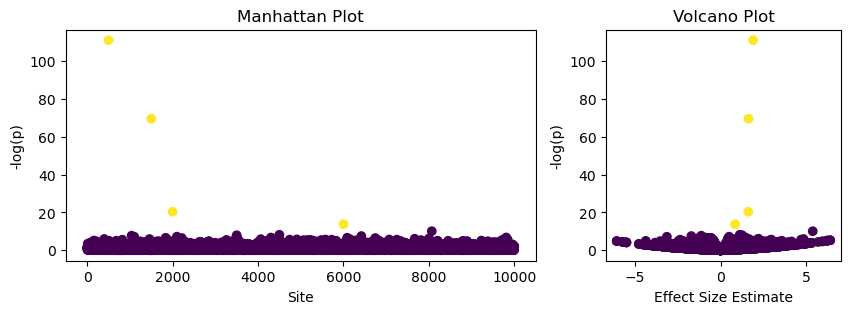

In [24]:
ss = 500

new_ps = phenos[:ss]
new_gs = genos[:ss,:]


## Running GWAS
ps = np.zeros(genome_size)
bs = np.zeros(genome_size)

for i in range(genome_size):
    X = new_gs[:,i]
    X = sm.add_constant(X, has_constant = 'add') 
    mod = sm.OLS(new_ps, X).fit()
    ps[i] = mod.pvalues[1]
    bs[i] = mod.params[1]
    
q_vals = fdrcorrection(ps, alpha = 0.05)

## Manhattan and Volcano Plots
fig, axs = plt.subplots(1,2,figsize = (10,3), gridspec_kw={'width_ratios': [2, 1],'height_ratios': [1],})

axs[0].scatter(range(genome_size), -np.log(ps), c = q_vals[0].astype(int))
axs[0].set_title('Manhattan Plot')
axs[0].set_xlabel('Site')
axs[0].set_ylabel('-log(p)')

axs[1].scatter(bs, -np.log(ps), c = q_vals[0].astype(int))
axs[1].set_title('Volcano Plot')
axs[1].set_xlabel('Effect Size Estimate')
axs[1].set_ylabel('-log(p)')

## Estimated vs Actual Effect Sizes
print('# of significant loci', q_vals[0].sum())
print('% of true effect loci found',q_vals[0][::500].sum()/20)

truths = effects[::500][q_vals[0][::500]] 
ests = bs[::500][q_vals[0][::500]]
diffs = truths - ests

print('\nTruth Estimate Difference')
for i in range(len(diffs)):
    print(truths[i],ests[i],diffs[i])

# of significant loci 8
% of true effect loci found 0.4

Truth Estimate Difference
1.9 1.8591395367578332 0.040860463242166745
1.7 1.6583110820211524 0.04168891797884755
1.6 1.5920187887220278 0.007981211277972244
1.5 1.1770862163473406 0.32291378365265944
1.3 1.5236695530654645 -0.22366955306546443
1.1 1.012655149580916 0.08734485041908413
0.8 0.8847418009427228 -0.08474180094272277
0.4 0.4379226064607331 -0.03792260646073309


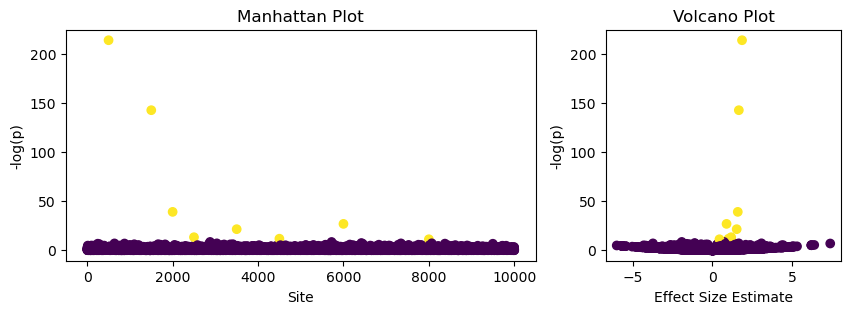

In [25]:
ss = 1000

new_ps = phenos[:ss]
new_gs = genos[:ss,:]


## Running GWAS
ps = np.zeros(genome_size)
bs = np.zeros(genome_size)

for i in range(genome_size):
    X = new_gs[:,i]
    X = sm.add_constant(X, has_constant = 'add') 
    mod = sm.OLS(new_ps, X).fit()
    ps[i] = mod.pvalues[1]
    bs[i] = mod.params[1]
    
q_vals = fdrcorrection(ps, alpha = 0.05)

## Manhattan and Volcano Plots
fig, axs = plt.subplots(1,2,figsize = (10,3), gridspec_kw={'width_ratios': [2, 1],'height_ratios': [1],})

axs[0].scatter(range(genome_size), -np.log(ps), c = q_vals[0].astype(int))
axs[0].set_title('Manhattan Plot')
axs[0].set_xlabel('Site')
axs[0].set_ylabel('-log(p)')

axs[1].scatter(bs, -np.log(ps), c = q_vals[0].astype(int))
axs[1].set_title('Volcano Plot')
axs[1].set_xlabel('Effect Size Estimate')
axs[1].set_ylabel('-log(p)')

## Estimated vs Actual Effect Sizes
print('# of significant loci', q_vals[0].sum())
print('% of true effect loci found',q_vals[0][::500].sum()/20)

truths = effects[::500][q_vals[0][::500]] 
ests = bs[::500][q_vals[0][::500]]
diffs = truths - ests

print('\nTruth Estimate Difference')
for i in range(len(diffs)):
    print(truths[i],ests[i],diffs[i])

/var/folders/9p/tdsfbkc524j05kttcf9bm6240000gp/T/ipykernel_53588/79891010.py:23: RuntimeWarning: divide by zero encountered in log
  axs[0].scatter(range(genome_size), -np.log(ps), c = q_vals[0].astype(int))
/var/folders/9p/tdsfbkc524j05kttcf9bm6240000gp/T/ipykernel_53588/79891010.py:28: RuntimeWarning: divide by zero encountered in log
  axs[1].scatter(bs, -np.log(ps), c = q_vals[0].astype(int))


# of significant loci 9
% of true effect loci found 0.4

Truth Estimate Difference
1.9 1.9103130341095618 -0.010313034109561858
1.7 1.7134463814420113 -0.01344638144201138
1.6 1.682293478544276 -0.08229347854427593
1.5 1.547063239324871 -0.04706323932487111
1.3 1.3612206989818385 -0.06122069898183846
1.1 1.0775650895387408 0.02243491046125934
0.8 0.8358936284738326 -0.035893628473832595
0.4 0.3744329307541559 0.02556706924584412


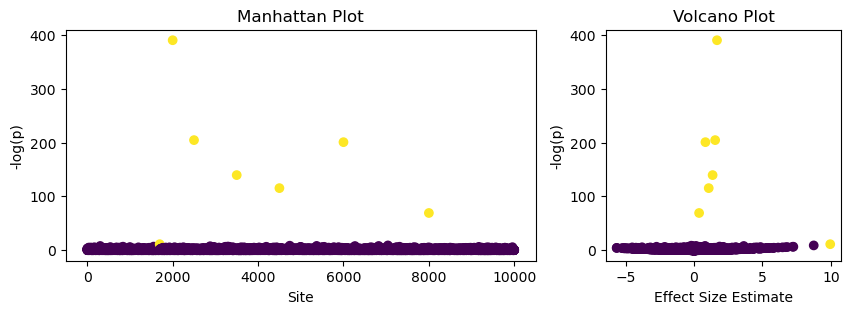

In [26]:
ss = 10000

new_ps = phenos[:ss]
new_gs = genos[:ss,:]


## Running GWAS
ps = np.zeros(genome_size)
bs = np.zeros(genome_size)

for i in range(genome_size):
    X = new_gs[:,i]
    X = sm.add_constant(X, has_constant = 'add') 
    mod = sm.OLS(new_ps, X).fit()
    ps[i] = mod.pvalues[1]
    bs[i] = mod.params[1]
    
q_vals = fdrcorrection(ps, alpha = 0.05)

## Manhattan and Volcano Plots
fig, axs = plt.subplots(1,2,figsize = (10,3), gridspec_kw={'width_ratios': [2, 1],'height_ratios': [1],})

axs[0].scatter(range(genome_size), -np.log(ps), c = q_vals[0].astype(int))
axs[0].set_title('Manhattan Plot')
axs[0].set_xlabel('Site')
axs[0].set_ylabel('-log(p)')

axs[1].scatter(bs, -np.log(ps), c = q_vals[0].astype(int))
axs[1].set_title('Volcano Plot')
axs[1].set_xlabel('Effect Size Estimate')
axs[1].set_ylabel('-log(p)')

## Estimated vs Actual Effect Sizes
print('# of significant loci', q_vals[0].sum())
print('% of true effect loci found',q_vals[0][::500].sum()/20)

truths = effects[::500][q_vals[0][::500]] 
ests = bs[::500][q_vals[0][::500]]
diffs = truths - ests

print('\nTruth Estimate Difference')
for i in range(len(diffs)):
    print(truths[i],ests[i],diffs[i])

/var/folders/9p/tdsfbkc524j05kttcf9bm6240000gp/T/ipykernel_53588/3714445381.py:23: RuntimeWarning: divide by zero encountered in log
  axs[0].scatter(range(genome_size), -np.log(ps), c = q_vals[0].astype(int))
/var/folders/9p/tdsfbkc524j05kttcf9bm6240000gp/T/ipykernel_53588/3714445381.py:28: RuntimeWarning: divide by zero encountered in log
  axs[1].scatter(bs, -np.log(ps), c = q_vals[0].astype(int))


# of significant loci 9
% of true effect loci found 0.45

Truth Estimate Difference
1.9 1.8869129871075963 0.01308701289240366
1.7 1.686754221790159 0.013245778209840964
1.6 1.6351173511574502 -0.03511735115745007
1.5 1.5215262488604573 -0.021526248860457287
1.3 1.348872448274903 -0.048872448274903
1.1 1.0889990080735656 0.011000991926434445
1.0 0.8678004046274594 0.13219959537254056
0.8 0.8342072217181342 -0.03420722171813417
0.4 0.3811792104313883 0.018820789568611718


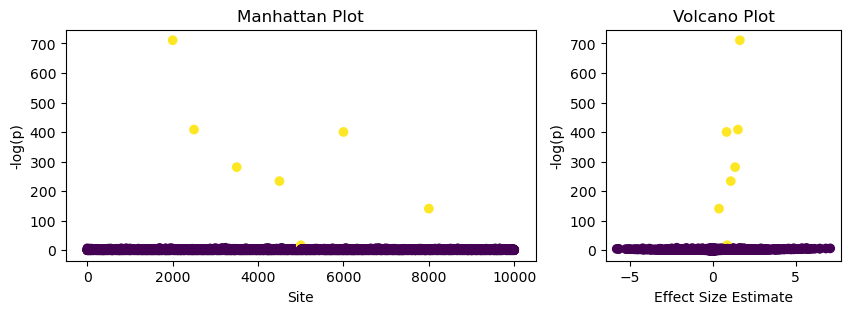

In [27]:
ss = 20000

new_ps = phenos[:ss]
new_gs = genos[:ss,:]


## Running GWAS
ps = np.zeros(genome_size)
bs = np.zeros(genome_size)

for i in range(genome_size):
    X = new_gs[:,i]
    X = sm.add_constant(X, has_constant = 'add') 
    mod = sm.OLS(new_ps, X).fit()
    ps[i] = mod.pvalues[1]
    bs[i] = mod.params[1]
    
q_vals = fdrcorrection(ps, alpha = 0.05)

## Manhattan and Volcano Plots
fig, axs = plt.subplots(1,2,figsize = (10,3), gridspec_kw={'width_ratios': [2, 1],'height_ratios': [1],})

axs[0].scatter(range(genome_size), -np.log(ps), c = q_vals[0].astype(int))
axs[0].set_title('Manhattan Plot')
axs[0].set_xlabel('Site')
axs[0].set_ylabel('-log(p)')

axs[1].scatter(bs, -np.log(ps), c = q_vals[0].astype(int))
axs[1].set_title('Volcano Plot')
axs[1].set_xlabel('Effect Size Estimate')
axs[1].set_ylabel('-log(p)')

## Estimated vs Actual Effect Sizes
print('# of significant loci', q_vals[0].sum())
print('% of true effect loci found',q_vals[0][::500].sum()/20)

truths = effects[::500][q_vals[0][::500]] 
ests = bs[::500][q_vals[0][::500]]
diffs = truths - ests

print('\nTruth Estimate Difference')
for i in range(len(diffs)):
    print(truths[i],ests[i],diffs[i])

In [28]:
sample_size = 20_000
genome_size = 10_000

## 1D array of environmental effects
envs = np.random.normal(0,1, size = sample_size)

## 1D array of effect sizes
effects = np.zeros(genome_size)
for i in range(20):
    effects[i*500] = ((20 - i)/20)*2

## 2D array of genotypes
geonos = np.random.choice([0,1,2],size = genome_size*sample_size).reshape(sample_size,genome_size)


## Calculating phenotypes
phenos = (effects*genos).sum(axis = 1) + envs


# of significant loci 5
% of true effect loci found 0.25

Truth Estimate Difference
1.9 1.8488746566536558 0.05112534334634411
1.7 1.6125039059015518 0.08749609409844816
1.6 1.445013990067771 0.1549860099322291
1.1 1.3662775140641692 -0.2662775140641691
0.8 0.924789456258388 -0.124789456258388


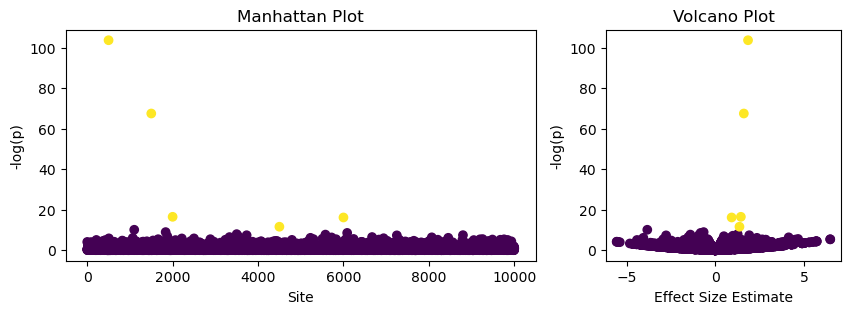

In [30]:
ss = 500

new_ps = phenos[:ss]
new_gs = genos[:ss,:]


run_gwas(new_gs, new_ps)

# of significant loci 8
% of true effect loci found 0.35

Truth Estimate Difference
1.9 1.8397258199535256 0.060274180046474335
1.7 1.7357347431038463 -0.03573474310384639
1.6 1.5697534425466393 0.0302465574533608
1.5 1.4048169480028365 0.09518305199716348
1.3 1.5810352152522111 -0.2810352152522111
1.1 1.0438750492713527 0.05612495072864743
0.8 0.8711667869144533 -0.07116678691445322


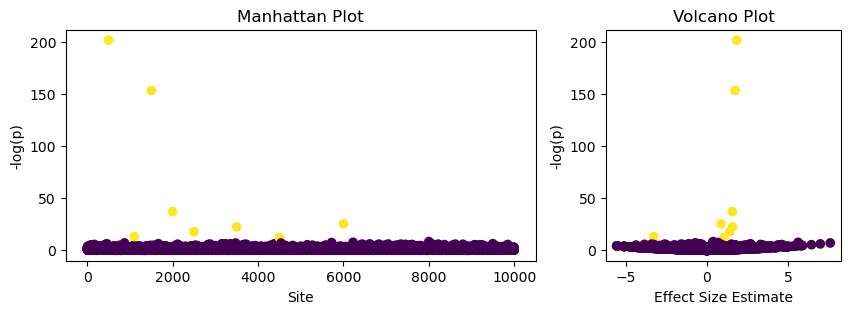

In [31]:
ss = 1000

new_ps = phenos[:ss]
new_gs = genos[:ss,:]


run_gwas(new_gs, new_ps)

/var/folders/9p/tdsfbkc524j05kttcf9bm6240000gp/T/ipykernel_53588/709838756.py:18: RuntimeWarning: divide by zero encountered in log
  axs[0].scatter(range(genome_size), -np.log(ps), c = q_vals[0].astype(int))
/var/folders/9p/tdsfbkc524j05kttcf9bm6240000gp/T/ipykernel_53588/709838756.py:23: RuntimeWarning: divide by zero encountered in log
  axs[1].scatter(bs, -np.log(ps), c = q_vals[0].astype(int))


# of significant loci 8
% of true effect loci found 0.4

Truth Estimate Difference
1.9 1.9117559874641423 -0.011755987464142414
1.7 1.6926018994124914 0.00739810058750856
1.6 1.6662191188934636 -0.06621911889346355
1.5 1.5068199398308804 -0.006819939830880362
1.3 1.3626085659616687 -0.06260856596166864
1.1 1.0645561006482878 0.03544389935171233
0.8 0.8181141863063257 -0.018114186306325664
0.4 0.38496408131610116 0.015035918683898863


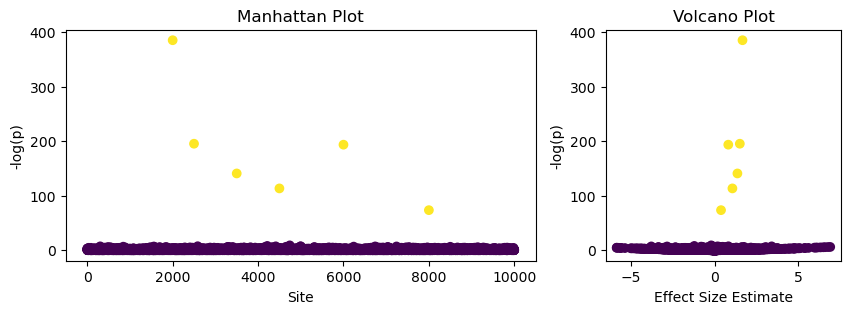

In [34]:
ss = 10000

new_ps = phenos[:ss]
new_gs = genos[:ss,:]


run_gwas(new_gs, new_ps)